# About
### Author:
    Thiago Luis Rodrigues Pinho @AILAB 
### Start Date:
    17/04/2020
### Objectives:
    Train a Siamese Manhattan Long Short-Term Memory and use it to evaluate text similarity for ALEI project
### Summary:
    1. Loading Data
        1.1 Sampling Data
    2. Treating Data
        2.1 Creating Text Pairs
        2.2 Embedding Text Pairs To Matrixes
    3. Training Siamese ManLSTM
        3.1 Creating and training model
        3.2 Evaluting the optimal number of clusters
    4. Predicting
        4.1 Finding the most similar text
        4.2 Generating Heatmap for Text Similarities
    5. Bibliography
    

# [ALEI] IAgrupador com Siamese Manhattan LSTM (MaLSTM)

In [122]:
from time import time

import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from fastparquet import write
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.python.keras.models import Model, Sequential, load_model
from tensorflow.python.keras.layers import Input, Embedding, LSTM, GRU, Conv1D, Conv2D, GlobalMaxPool1D, Dense, Dropout

from util import make_w2v_embeddings
from util import split_and_zero_padding
from util import ManDist
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set()

## 1. Loading data

In [2]:
%%time 
RELATIVE_FOLDER_PATH = "./data/"
VECTOR_MODEL_NAME = "pt_core_news_sm"
NLP_SPACY = spacy.load(VECTOR_MODEL_NAME)
filename = "data_preprocessed"
stopwords_set = set(STOP_WORDS)

parquet_filename = RELATIVE_FOLDER_PATH + filename + ".parquet.gzip"
ailab_df = pd.read_parquet(parquet_filename, columns=['process_class', 'text', 'process_id'])
print(ailab_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   process_class  2036 non-null   object
 1   text           2036 non-null   object
 2   process_id     2036 non-null   object
dtypes: object(3)
memory usage: 47.8+ KB
None
CPU times: user 5.05 s, sys: 302 ms, total: 5.36 s
Wall time: 5.36 s


## 2. Treating Data

In [62]:
num_samples = 100
sample_df = ailab_df.sample(n=num_samples)
sample_df = sample_df.drop_duplicates(subset='process_id')
print(sample_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92 entries, 1335 to 479
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   process_class  92 non-null     object
 1   text           92 non-null     object
 2   process_id     92 non-null     object
dtypes: object(3)
memory usage: 2.9+ KB
None


### 2.1 Creating Text Pairs
It's necessary to prepare data so each input is a pair os texts and if they are close

In [63]:
%time
text_pairs = []
comparing_same_text = True
for question_1_index, question_1_row in sample_df.iterrows():
    question_1_text = question_1_row['text']
    question_1_id = question_1_row['process_id']
    question_1_class = question_1_row['process_class']
    for question_2_index, question_2_row in sample_df.iterrows():
        if not comparing_same_text and question_1_index == question_2_index:
            continue
        question_2_text = question_2_row['text']
        question_2_id = question_2_row['process_id']
        question_2_class = question_2_row['process_class']
        is_same_class = question_1_class == question_2_class
        text_pairs.append([question_1_id, question_1_text, question_2_id, question_2_text, is_same_class])

train_df = pd.DataFrame(text_pairs, columns=['question1_id', 'question1', 'question2_id', 'question2', 'is_duplicate'])
print(train_df.info())

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11 µs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8464 entries, 0 to 8463
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   question1_id  8464 non-null   object
 1   question1     8464 non-null   object
 2   question2_id  8464 non-null   object
 3   question2     8464 non-null   object
 4   is_duplicate  8464 non-null   bool  
dtypes: bool(1), object(4)
memory usage: 272.9+ KB
None


#### Storing partial results

In [64]:
pair_text_filename = "text_pairs" + str(num_samples)
pair_text_parquet_filename = RELATIVE_FOLDER_PATH + pair_text_filename + ".parquet.gzip"

In [65]:
write(pair_text_parquet_filename, train_df, compression='gzip')

#### Loading partial results

In [66]:
pair_text_df = pd.read_parquet(pair_text_parquet_filename)
print(pair_text_df.head())

  question1_id                                          question1  \
0      1061009  ante exposto declaro extinto feito resolucao m...   
1      1061009  ante exposto declaro extinto feito resolucao m...   
2      1061009  ante exposto declaro extinto feito resolucao m...   
3      1061009  ante exposto declaro extinto feito resolucao m...   
4      1061009  ante exposto declaro extinto feito resolucao m...   

  question2_id                                          question2  \
0      1061009  ante exposto declaro extinto feito resolucao m...   
1      1134520  advocaciageral uniao procuradoria regional uni...   
2      1057381  pretendidas exclusoes base calculo folha salar...   
3      1040710  diretamente deducao quantia recebida constitui...   
4      1051155  documento recebido eletronicamente origem docu...   

   is_duplicate  
0          True  
1          True  
2          True  
3         False  
4         False  


### 2.2 Embedding Text Pairs To Matrixes

In [67]:
%time
for q in ['question1', 'question2']:
    pair_text_df[q + '_n'] = pair_text_df[q]

# Make word2vec embeddings
embedding_dim = 300
max_seq_length = 40
use_w2v = True

pair_text_df, embeddings = make_w2v_embeddings(pair_text_df, embedding_dim=embedding_dim, empty_w2v=not use_w2v)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 6.91 µs
Loading word2vec model(it may takes 2-3 mins) ...
1,000 sentences embedded.
2,000 sentences embedded.
3,000 sentences embedded.
4,000 sentences embedded.
5,000 sentences embedded.
6,000 sentences embedded.
7,000 sentences embedded.
8,000 sentences embedded.


#### Storing partial results

In [68]:
embedded_pairs_filename = "embedded_pairs" + str(num_samples)
embedding_filename = 'embeddings' + str(num_samples)
embedded_pairs_parquet_filename = RELATIVE_FOLDER_PATH + embedded_pairs_filename + ".parquet.gzip"
embedding_npy_filename = RELATIVE_FOLDER_PATH + embedded_pairs_filename + ".npy"

In [69]:
write(embedded_pairs_parquet_filename, pair_text_df, compression='gzip')
np.save(embedding_npy_filename, embeddings)

#### Loading partial results

In [70]:
embedded_pairs_df = pd.read_parquet(embedded_pairs_parquet_filename)
embeddings = np.load(embedding_npy_filename)
print(embedded_pairs_df.info())
print(embeddings)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8464 entries, 0 to 8463
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   question1_id  8464 non-null   object
 1   question1     8464 non-null   object
 2   question2_id  8464 non-null   object
 3   question2     8464 non-null   object
 4   is_duplicate  8464 non-null   bool  
 5   question1_n   8464 non-null   object
 6   question2_n   8464 non-null   object
dtypes: bool(1), object(6)
memory usage: 405.1+ KB
None
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.03857422  0.37890625  0.13867188 ... -0.16699219 -0.04125977
  -0.30273438]
 [-1.62352372  0.60145798 -1.28576962 ...  0.41427751 -0.77134373
  -0.39726442]
 ...
 [-0.0559082   0.11767578  0.2109375  ... -0.04272461  0.14746094
  -0.18261719]
 [ 0.05078125 -0.02258301 -0.16992188 ... -0.02075195  0.12695312
  -0.23339844]
 [-0.1640625  -0.06176758 -0.05419922 ... -0.03295898  0.1

#### Spliting Testind and Prediction Data

In [85]:
test_size = int(len(pair_text_df) * 0.2)
train_df, test_df = train_test_split(embedded_pairs_df, test_size=test_size)
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1692 entries, 4341 to 5800
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   question1_id  1692 non-null   object
 1   question1     1692 non-null   object
 2   question2_id  1692 non-null   object
 3   question2     1692 non-null   object
 4   is_duplicate  1692 non-null   bool  
 5   question1_n   1692 non-null   object
 6   question2_n   1692 non-null   object
dtypes: bool(1), object(6)
memory usage: 94.2+ KB
None


## 3. Training Siamese ManLSTM

In [86]:
# Split to train validation
validation_size = int(len(train_df) * 0.2)
training_size = len(train_df) - validation_size

X = train_df[['question1_n', 'question2_n']]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

X_train = split_and_zero_padding(X_train, max_seq_length)
X_validation = split_and_zero_padding(X_validation, max_seq_length)

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

### 3.1 Creating and training model

In [87]:
%time
# Model variables
gpus = 1
batch_size = 1024 * gpus
n_epoch = 50
n_hidden = 50

# Define the shared model
x = Sequential()
x.add(Embedding(len(embeddings), embedding_dim,
                weights=[embeddings], input_shape=(max_seq_length,), trainable=False))
# CNN
# x.add(Conv1D(250, kernel_size=5, activation='relu'))
# x.add(GlobalMaxPool1D())
# x.add(Dense(250, activation='relu'))
# x.add(Dropout(0.3))
# x.add(Dense(1, activation='sigmoid'))
# LSTM
x.add(LSTM(n_hidden))

shared_model = x

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

# Pack it all up into a Manhattan Distance model
malstm_distance = ManDist()([shared_model(left_input), shared_model(right_input)])
model = Model(inputs=[left_input, right_input], outputs=[malstm_distance])

if gpus >= 2:
    # `multi_gpu_model()` is a so quite buggy. it breaks the saved model.
    model = tf.keras.utils.multi_gpu_model(model, gpus=gpus)
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model.summary()
shared_model.summary()

# Start trainings
training_start_time = time()
malstm_trained = model.fit([X_train['left'], X_train['right']], Y_train,
                           batch_size=batch_size, epochs=n_epoch,
                           validation_data=([X_validation['left'], X_validation['right']], Y_validation))
training_end_time = time()
print("Training time finished.\n%d epochs in %12.2f" % (n_epoch,
                                                        training_end_time - training_start_time))

model.save('./data/SiameseLSTM_' + str(num_samples) + '.h5')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50)           4143000     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
man_dist_1 (ManDist)        

Epoch 44/50
5418/5418 [==============================] - 4s 653us/sample - loss: 0.1422 - acc: 0.8667 - val_loss: 0.1414 - val_acc: 0.8678
Epoch 45/50
5418/5418 [==============================] - 4s 661us/sample - loss: 0.1409 - acc: 0.8686 - val_loss: 0.1404 - val_acc: 0.8678
Epoch 46/50
5418/5418 [==============================] - 4s 694us/sample - loss: 0.1395 - acc: 0.8688 - val_loss: 0.1388 - val_acc: 0.8678
Epoch 47/50
5418/5418 [==============================] - 4s 671us/sample - loss: 0.1383 - acc: 0.8690 - val_loss: 0.1379 - val_acc: 0.8678
Epoch 48/50
5418/5418 [==============================] - 4s 651us/sample - loss: 0.1371 - acc: 0.8690 - val_loss: 0.1367 - val_acc: 0.8685
Epoch 49/50
5418/5418 [==============================] - 4s 649us/sample - loss: 0.1357 - acc: 0.8693 - val_loss: 0.1350 - val_acc: 0.8685
Epoch 50/50
5418/5418 [==============================] - 4s 663us/sample - loss: 0.1339 - acc: 0.8693 - val_loss: 0.1323 - val_acc: 0.8685
Training time finished.
50 

## 3.3 Evaluating the model

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


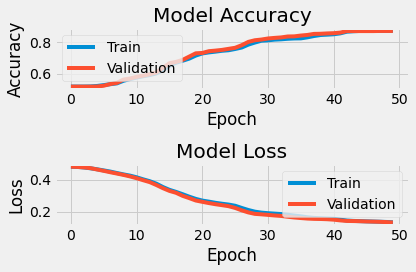

0.8685(max: 0.8685)
Done.


In [88]:
%time
# Plot accuracy
plt.subplot(211)
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(212)
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout(h_pad=1.0)
plt.savefig('./data/history-graph_' + str(num_samples) + '.png')
plt.show()

print(str(malstm_trained.history['val_acc'][-1])[:6] +
      "(max: " + str(max(malstm_trained.history['val_acc']))[:6] + ")")
print("Done.")

## 4. Predicting 

In [89]:
model = tf.keras.models.load_model('./data/SiameseLSTM_' + str(num_samples) + '.h5', custom_objects={'ManDist': ManDist})
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50)           4143000     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
man_dist_1 (ManDist)            (None, 1)            0           sequential_1[1][0]         

### 4.1 Finding the most similar text

In [71]:
%time
matching_questions = []

choosen_question_id = test_df['question1_id'].to_list()[0]
print(choosen_question_id)
    
choosen_question_mask = test_df['question1_id'].values == choosen_question_id
print(len(test_df))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
881223
2000


In [72]:
# Split to dicts and append zero padding.
X_test = split_and_zero_padding(test_df[choosen_question_mask], max_seq_length)

# Make sure everything is ok
assert X_test['left'].shape == X_test['right'].shape
# --

prediction = model.predict([X_test['left'], X_test['right']])
closests_text = np.argmax(prediction)
most_similar_text = test_df[choosen_question_mask][:1]
print(most_similar_text['question1'].values[0][:200])
print(most_similar_text['question2'].values[0][:200])

evento senta procedimento comum juizado especial civel 9320124047113rs autor irineu tillwitz advogado luiz gustavo capitani silva reimann uniao fazenda nacional sentenca vistos dispensado relatorio ST
pagina separacao gerada automaticamente evento voto data evento


### 4.3 Generating Heatmap for Text Similarities

In [ ]:
unique_ids_list = embedded_pairs_df['question1_id'].unique().tolist()

unique_ids_list.sort()
print(unique_ids_list)

In [ ]:
dimension = len(unique_ids_list)
distances_mapped = dict()
for choosen_id in unique_ids_list:
    choosen_question_mask = embedded_pairs_df['question1_id'].values == choosen_id
    compared_df = embedded_pairs_df[choosen_question_mask]
    
    compared_df.sort_values(by=['question2_id'], inplace=True)
    
    compared_ids_list = compared_df['question2_id'].to_list()
    if compared_ids_list != unique_ids_list:
        break
        print("An error ocurred")
    # Split to dicts and append zero padding.
    X_test = split_and_zero_padding(compared_df, max_seq_length)

    # Make sure everything is ok
    assert X_test['left'].shape == X_test['right'].shape
    # --

    predictions_list = model.predict([X_test['left'], X_test['right']])
    distances_mapped[choosen_id] = [text_distance[0] for text_distance in predictions_list.tolist()]

#### Reordering rows and columns to improve visualisation

In [104]:
mapped_distances_df = pd.DataFrame.from_dict(distances_mapped, orient='index',
                       columns=unique_ids_list)
mapped_distances_df.head()

,1010566,1011661,1015067,1017083,1022138,1026327,1036059,1037728,1040710,1044362,...,916369,946628,980179,981655,985162,986082,986097,986453,986596,991397
1010566,1.000000,0.082138,0.000054,0.079212,0.750660,0.082023,0.082214,0.082838,0.081585,0.080421,...,0.761851,0.000040,0.081711,0.663153,0.752876,0.012436,0.752543,0.655649,0.753154,0.084068
1011661,0.082138,1.000000,0.000045,0.949580,0.066321,0.987722,0.964985,0.978620,0.981080,0.961150,...,0.067973,0.000077,0.981446,0.075873,0.067030,0.016759,0.068108,0.078216,0.066078,0.933355
1015067,0.000054,0.000045,1.000000,0.000045,0.000048,0.000045,0.000045,0.000045,0.000044,0.000044,...,0.000047,0.000003,0.000045,0.000048,0.000048,0.000009,0.000048,0.000048,0.000048,0.000046
1017083,0.079212,0.949580,0.000045,1.000000,0.064653,0.947106,0.932140,0.948222,0.938399,0.937910,...,0.065717,0.000078,0.948463,0.073426,0.065323,0.016701,0.065687,0.075321,0.064275,0.892640
1022138,0.750660,0.066321,0.000048,0.064653,1.000000,0.066093,0.066870,0.066795,0.065727,0.065755,...,0.915409,0.000035,0.065825,0.816508,0.945233,0.013151,0.924026,0.810404,0.949474,0.068260


In [108]:
mapped_distances_df.sort_values(by=['1010566'], ascending=False, inplace=True)
mapped_distances_df = mapped_distances_df[mapped_distances_df.index]


,1010566,1011661,1015067,1017083,1022138,1026327,1036059,1037728,1040710,1044362,...,916369,946628,980179,981655,985162,986082,986097,986453,986596,991397
1010566,1.000000,0.082138,0.000054,0.079212,0.750660,0.082023,0.082214,0.082838,0.081585,0.080421,...,0.761851,0.000040,0.081711,0.663153,0.752876,0.012436,0.752543,0.655649,0.753154,0.084068
1145986,0.853393,0.076770,0.000051,0.074089,0.828299,0.076696,0.076846,0.077480,0.076189,0.075368,...,0.805985,0.000039,0.076377,0.731620,0.833589,0.011705,0.823953,0.733165,0.828601,0.079177
825438,0.762522,0.069463,0.000048,0.067462,0.935648,0.069396,0.069742,0.070042,0.068992,0.068353,...,0.919476,0.000035,0.069094,0.819480,0.946632,0.012908,0.949847,0.816957,0.937065,0.071684
916369,0.761851,0.067973,0.000047,0.065717,0.915409,0.067816,0.067542,0.068411,0.067463,0.066781,...,1.000000,0.000033,0.067501,0.820737,0.932999,0.012742,0.914013,0.804292,0.931345,0.070233
1139419,0.759513,0.065588,0.000048,0.064617,0.941152,0.065415,0.065788,0.066093,0.065052,0.064534,...,0.920498,0.000034,0.065123,0.823936,0.947120,0.013169,0.927534,0.802456,0.951243,0.067380


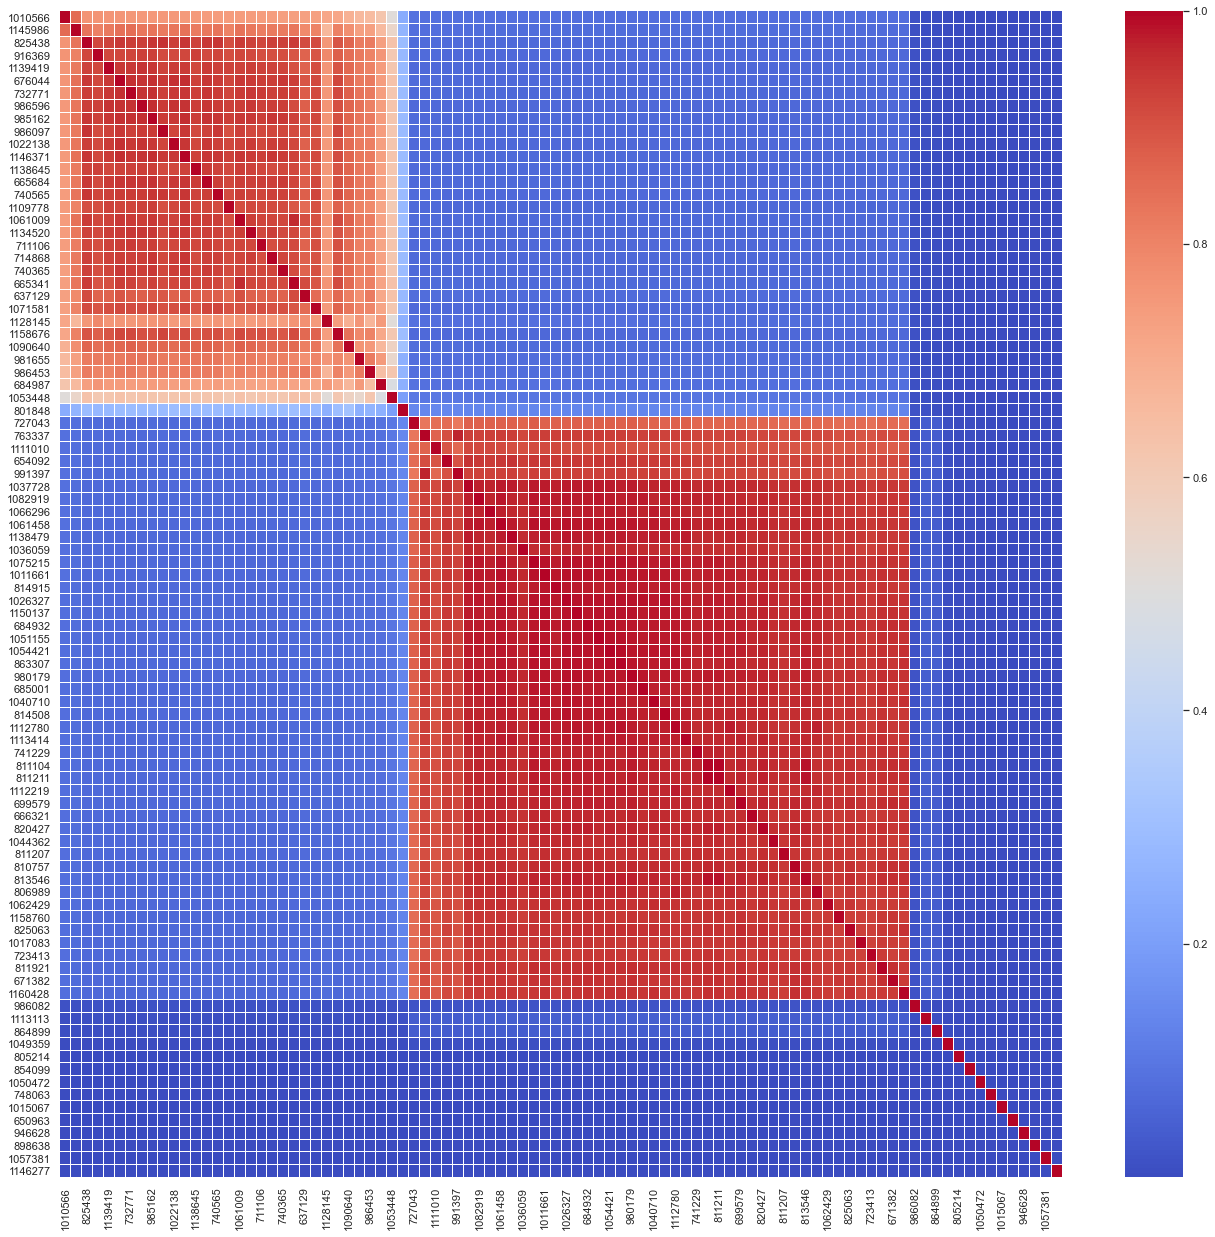

In [121]:
plt.figure(figsize=(20, 20))
ax = sns.heatmap(mapped_distances_df, cmap='coolwarm', linewidths=0.01)

## 5. Bibliography

Siamese-LSTM. Sang-Kil Park. [Available at](https://github.com/likejazz/Siamese-LSTM) Last visited: 17/04/2020
